In [27]:
# import the necessary packages
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import precision_recall_fscore_support as score_prfs
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import imutils
import cv2
import os

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])

    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)

    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)

    # return the flattened histogram as the feature vector
    return hist.flatten()

In [3]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    print("Loading from npy files...")
    X = np.load("Image_n_Labels/trainImages.npy")
    y = np.load("Image_n_Labels/trainLabels.npy")
    print("Training images and labels are loaded in variables ==> X,y")
    print("Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns('../../GTSRB/train/Final_Training/Images/')
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("training images and labels are read from the dataset directory")
    print("training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("training labels saved to Image_n_Labels/trainingLabels.npy for further use")

Loading from npy files...
Training images and labels are loaded in variables ==> X,y
Number of training Images 39209 
Number of Labels 39209


In [13]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = y
# loop over the input images
for i in range(0,len(X)):
# for i in range(0,10):
    image = X[i]
    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    # update the raw images, features, and labels matricies,
    # respectively
    rawImages.append(pixels)
    features.append(hist)

    # show an update every 3,000 images
    if i > 0 and i % 3000 == 0:
        print("[INFO] processed {}/{}".format(i, len(X)))

[INFO] processed 3000/39209
[INFO] processed 6000/39209
[INFO] processed 9000/39209
[INFO] processed 12000/39209
[INFO] processed 15000/39209
[INFO] processed 18000/39209
[INFO] processed 21000/39209
[INFO] processed 24000/39209
[INFO] processed 27000/39209
[INFO] processed 30000/39209
[INFO] processed 33000/39209
[INFO] processed 36000/39209
[INFO] processed 39000/39209


In [14]:
print("[INFO] hsv color histogram features : {}x{}".format(X.shape[0],len(features[0])))

print("[INFO] raw pixel features : {}x{}".format(X.shape[0],len(rawImages[0])))
print("[INFO] shape of labels : {}".format(labels.shape))

[INFO] hsv color histogram features : 39209x512
[INFO] raw pixel features : 39209x3072
[INFO] shape of labels : (39209,)


In [15]:
# show some information on the memory consumed by the raw images
# matrix and features matrix
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 117.63MB
[INFO] features matrix: 78.42MB


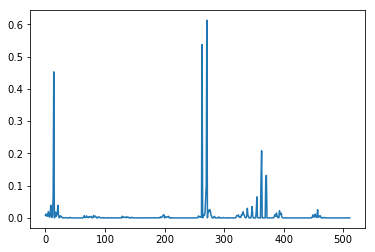

In [16]:
plt.plot(features[149])
plt.show()

In [17]:
# take the  data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(features,
    labels, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels,
    test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 26465
validation data points: 2941
testing data points: 9803


In [18]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
kVals = range(1, 30, 2)
accuracies = []
 
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in xrange(1, 30, 2):
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(trainData, trainLabels)

    # evaluate the model and update the accuracies list
    score = model.score(valData, valLabels)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

# find the value of k that has the largest accuracy
i = np.argmax(accuracies)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],
    accuracies[i] * 100))

k=1, accuracy=96.70%
k=3, accuracy=92.93%
k=5, accuracy=89.39%
k=7, accuracy=86.33%
k=9, accuracy=83.99%
k=11, accuracy=80.86%
k=13, accuracy=78.14%
k=15, accuracy=75.65%
k=17, accuracy=74.33%
k=19, accuracy=72.02%
k=21, accuracy=70.59%
k=23, accuracy=67.97%
k=25, accuracy=67.12%
k=27, accuracy=65.56%
k=29, accuracy=63.65%
k=1 achieved highest accuracy of 96.70% on validation data


In [21]:
# train and evaluate a k-NN classifer on the histogram
# representations
# if os.path.isfile('c'
name = "clf/clf_knn_cv_clrhist.pkl"
if os.path.isfile(name):
    print("[INFO] loading classifier: KNN ={} trained on color histogram features...".format(kVals[i]))
    model= joblib.load(name)
    print("[INFO] Classifer is loaded as instance ::model::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \KNN = {}".format(kVals[i]))
    model = KNeighborsClassifier(n_neighbors=1,n_jobs=2)
    model.fit(trainData, trainLabels)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(model, name) 
    print("[INFO] Classifier Saved")

[INFO] loading classifier: KNN =1 trained on color histogram features...
[INFO] Classifer is loaded as instance ::model::


In [28]:
predictions = model.predict(testData)
 
# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(testLabels, predictions))

EVALUATION ON TESTING DATA
             precision    recall  f1-score   support

          0       0.98      0.95      0.97        44
          1       0.96      0.96      0.96       594
         10       0.94      0.95      0.95       461
         11       0.97      0.97      0.97       291
         12       0.99      0.97      0.98       548
         13       0.95      0.96      0.95       549
         14       0.98      0.99      0.99       197
         15       0.97      0.98      0.97       152
         16       0.97      0.94      0.96       108
         17       0.99      0.98      0.99       286
         18       0.98      0.95      0.96       288
         19       0.96      1.00      0.98        53
          2       0.97      0.94      0.96       560
         20       0.95      0.99      0.97        90
         21       0.99      0.98      0.98        82
         22       0.92      0.98      0.95       107
         23       0.98      0.99      0.99       138
         24       

In [24]:
def testing_on_data():
    n = np.random.randint(0, high=len(testLabels))
    test1 =X[n]
    plt.imshow(test1)
    plt.show()
    t1_true = y[n]
    t1_feat =  extract_color_histogram(test1)
    t1_predict = model.predict(t1_feat)
    print("==========")
    print("True :{}\npredicted:{}\n".format(t1_true,t1_predict[0]))
    # show the prediction
    print("I think that belongs to class: {}".format(t1_predict))
    print("==========")
    font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 10)
    img = Image.fromarray(test1)
    draw = ImageDraw.Draw(img)
    draw.text((0,0), str(t1_predict), (0,255,0), font=font)
    draw = ImageDraw.Draw(img)
    plt.show(img)     

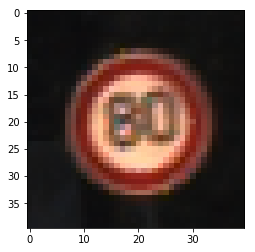

True :5
predicted:5

I think that belongs to class: ['5']


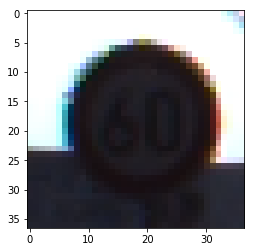

True :3
predicted:3

I think that belongs to class: ['3']


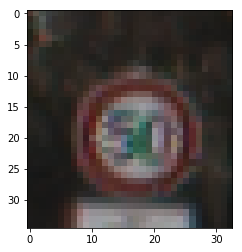

True :2
predicted:2

I think that belongs to class: ['2']


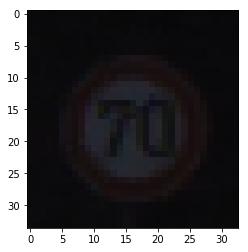

True :4
predicted:4

I think that belongs to class: ['4']


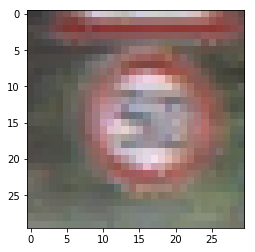

True :2
predicted:2

I think that belongs to class: ['2']


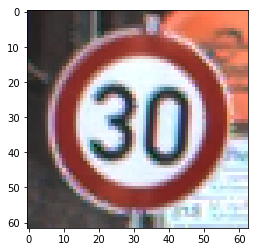

True :1
predicted:1

I think that belongs to class: ['1']


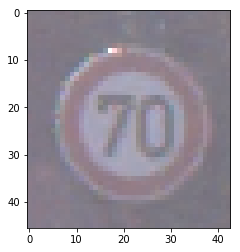

True :4
predicted:4

I think that belongs to class: ['4']


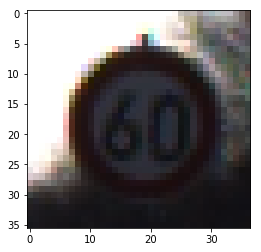

True :3
predicted:3

I think that belongs to class: ['3']


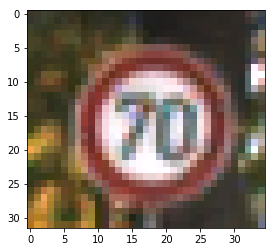

True :4
predicted:4

I think that belongs to class: ['4']


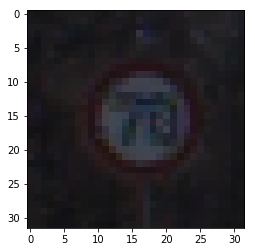

True :4
predicted:4

I think that belongs to class: ['4']


In [25]:
for i in range(10):
    testing_on_data()